## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import sys
sys.path.insert(1, '..')

from scipy.stats import beta
from scipy.stats import lognorm
import h5py
import corner
import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
import get_wavelet_params as wp
from matplotlib import rc
from astropy import constants as const
from math import sqrt

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [ ]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetMedianData(p, det = 'H1'):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ## Grab Livingston data
    f = GetBWDir(p) + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1 #, d2, d3, d4, d5

def GetInjectedData(p, det = 'H1'):

    f = GetBWDir(p) + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data

## Helper functions

In [12]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def EllString(ell):
    return str(ell).replace('.','p')

def GetBaseDir(ell, dist_mpc, mass):
    ell = EllString(ell)
    dist_mpc = str(dist_mpc)
    mass = str(mass)

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/Frames" \
             + "/dCS_" + ell + "/dCS_" + ell + "_mtotal_" + mass + "_dist_" + dist_mpc \
             + "/BW_dCS_" + ell + "_mtotal_" + mass + "_dist_" + dist_mpc + "_1e6/trigtime_1126259462.410700560_0.0_0.0_0/"  
    
    print(base_dir)

    return base_dir

def EllinKm(ell_string, mass):
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value

## Plot BW reconstructed waveforms

/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
0.0 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
[-5.59423828 -5.59375    -5.59326172 ...  2.40429688  2.40478516
  2.40527344]
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0p1_mtotal_68_dist_400/BW_dCS_0p1_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
10.04105025874085 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0p1_mtotal_68_dist_400/BW_dCS_0p1_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0p1_mtotal_68_dist_400/BW_dCS_0p1_mtotal_68_dist_400/trigtime_1126259462.4107

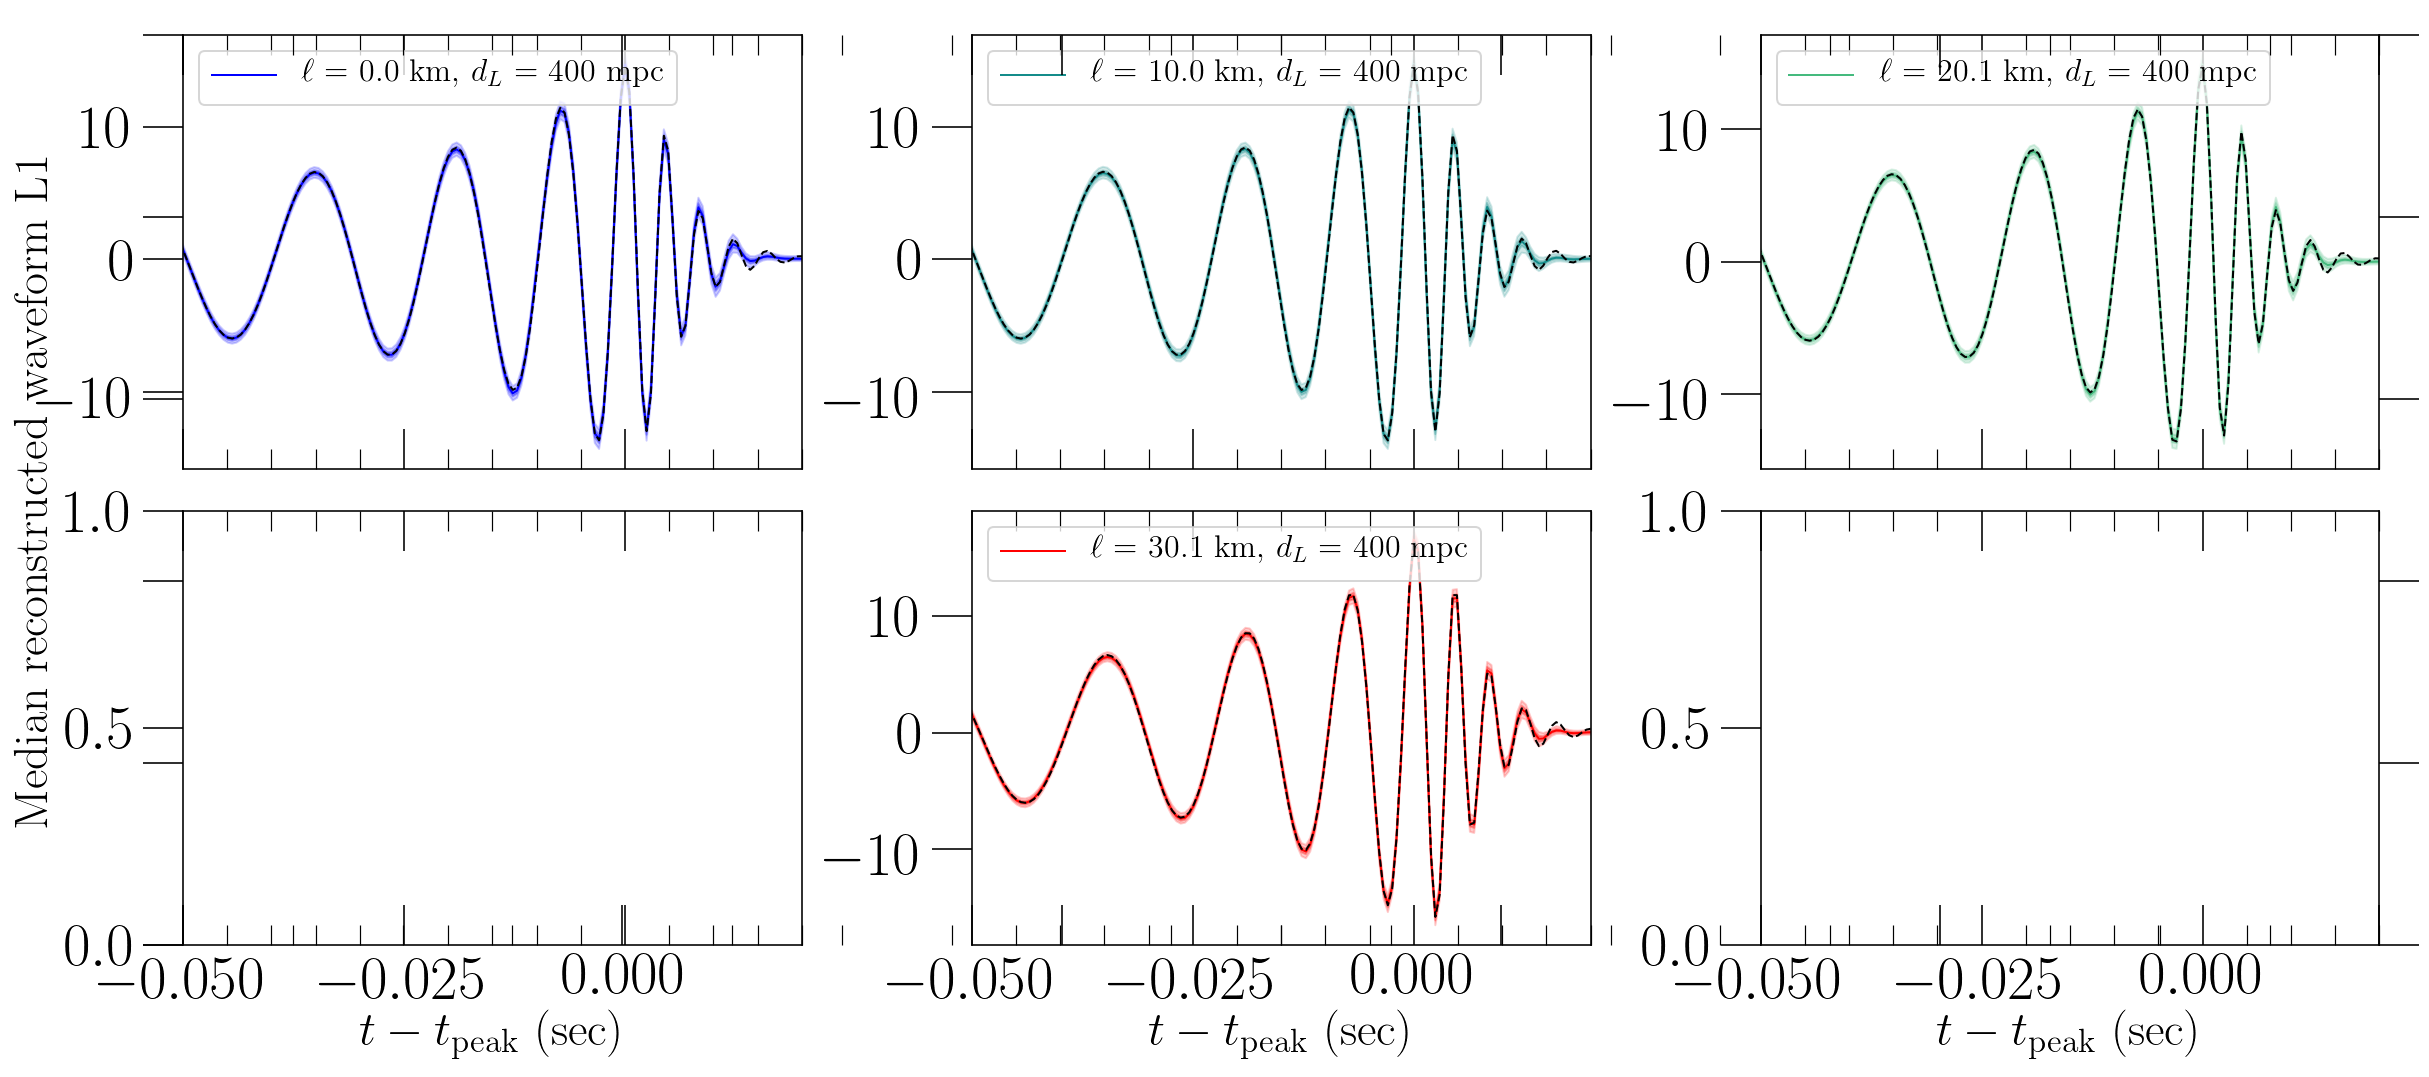

In [102]:
def GetMedianData(ell, dist_mpc, mass):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    base_dir = GetBaseDir(ell, dist_mpc, mass)
 
    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_L1.dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1, d2, d3, d4, d5


def GetInjectedData(ell, dist_mpc, mass):
    
    base_dir = GetBaseDir(ell, dist_mpc, mass)
    print(base_dir)
    
    f = base_dir + 'post/whitened_data_L1.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    #print(data)
    print(time)
    return time, data
    
def PlotMedianData(ax, ell, dist_mpc, mass, color):
    
    ## Plot the Bayeswave data
    time, d1, d2, d3, d4, d5 = GetMedianData(ell, dist_mpc, mass)
    label = r'$\ell$ = ' + EllinKm(ell, mass) + ', $d_L$ = ' + str(dist_mpc) + ' mpc' 
    
    ax.plot(time, d1, '-', lw = 1.0, alpha = 1.0, color=color, label=label)  
    ax.fill_between(time, d2, d3, alpha = 0.3, color=color, edgecolor=None)
    ax.fill_between(time, d4, d5, alpha = 0.2, color=color, edgecolor=None)
    
    time, data = GetInjectedData(ell, dist_mpc, mass)
    ax.plot(time, data, '--', color='black', lw = 1.0, alpha=1.0)
    ax.set_xlim(-0.05, 0.02)
    ax.legend(frameon=True, fontsize=16, loc='upper left')
        
fig, axarr = plt.subplots(2,3, figsize=(18, 8), sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

my_mass = 68 
my_dist = 400

PlotMedianData(axarr[0][0], 0.0, my_dist, my_mass, 'blue')
PlotMedianData(axarr[0][1], 0.1, my_dist, my_mass, '#148c8a')
PlotMedianData(axarr[0][2], 0.2, my_dist, my_mass, '#45ba7e')
#PlotMedianData(axarr[1][0], 0.25, my_dist, my_mass, 'green')
PlotMedianData(axarr[1][1], 0.3, my_dist, my_mass, 'red')
#PlotMedianData(axarr[1][2], 0.226, snr_low, '#45ba7e')

plt.ylabel('Median reconstructed waveform L1')
for i in range(3):
    axarr[1][i].set_xlabel('$t - t_\mathrm{peak}$ (sec)')

plt.tight_layout()
plt.savefig('Bayeswave.pdf')

plt.show()



## Plot evidences

In [15]:
def GetEvidenceTemps(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/signal_evidence.dat"
    temp, evidence = np.loadtxt(f, comments="#",usecols=([0, 1]),unpack=True)
    print(len(temp))
    
    return temp, evidence

def GetEvidence(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/evidence.dat"
 
    ev, variance = np.loadtxt(f, comments="#",usecols=([1, 2]),unpack=True)
    
    ev = ev[0]
    ev_err = sqrt(variance[0])
    
    return ev, ev_err


854039.995414 854042.328235
853980.225178 853981.483185
853941.403552 853948.101595


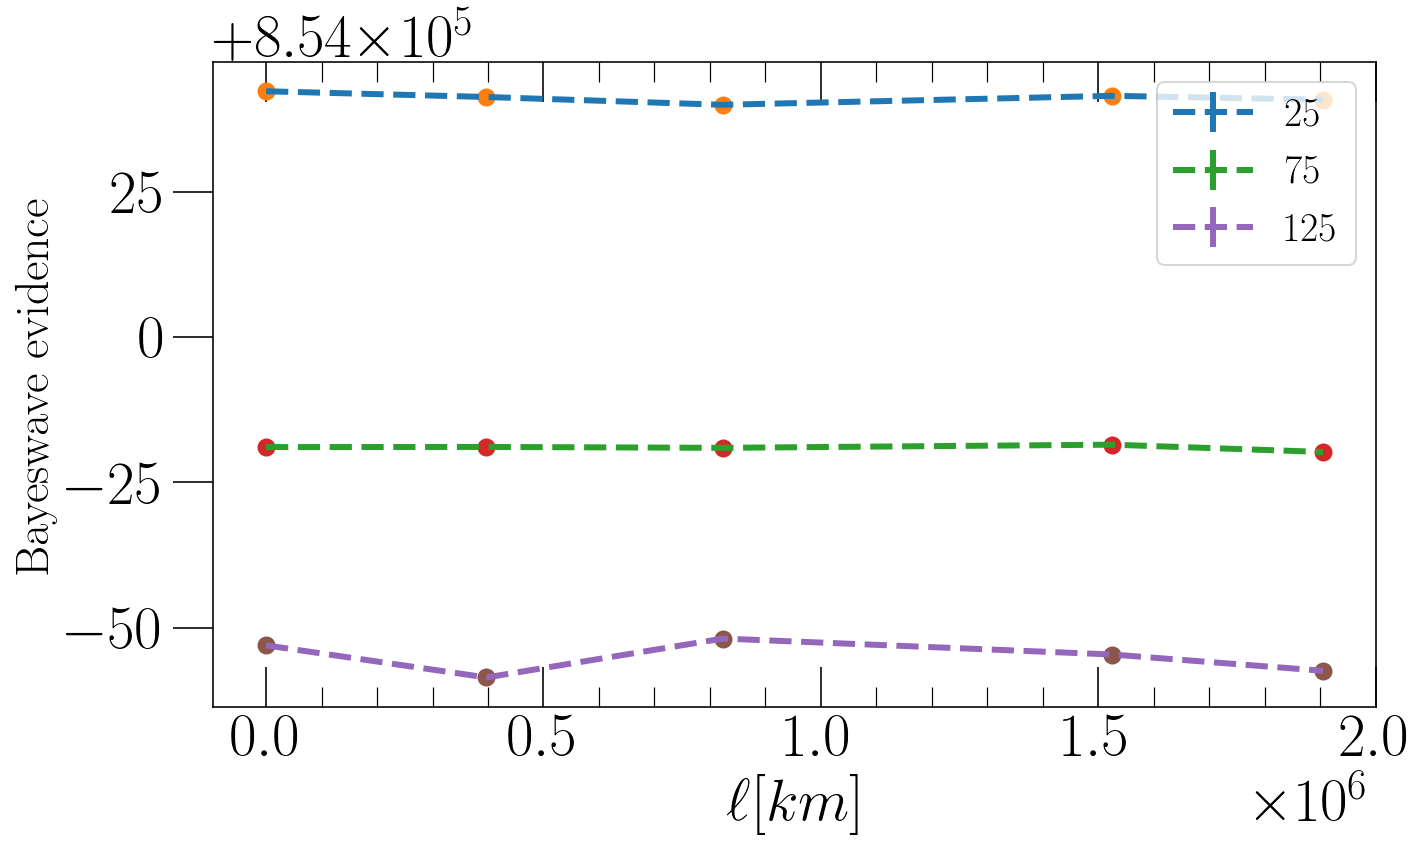

In [17]:
fig = plt.figure(figsize=(10, 6))
    
ell = ["0p0", "0p25", "0p3", "0p35", "0p37"]
ell_km = np.array([EllinKm(l, 68) for l in ell])**4

for SNR in ['25','75','125']:
    
    BW_Evidence = np.zeros(len(ell))
    BW_Evidence_err = np.zeros(len(ell))

    for i, l in enumerate(ell):
        base_dir = 'dCS_' + l + '_' + SNR
        ev, ev_err = GetEvidence(base_dir) 
        BW_Evidence[i] = ev
        BW_Evidence_err[i] = ev_err
    
    plt.errorbar(ell_km, BW_Evidence, yerr=BW_Evidence_err, linestyle='--', label=SNR, linewidth=3)
    plt.plot(ell_km, BW_Evidence, 'o', markersize=8)
    print(min(BW_Evidence), max(BW_Evidence))
    
#plt.ylabel(r'Quantity relative to $\ell = 0$ value', fontsize=30)
plt.xlabel(r'$\ell [km]$', fontsize=30)
plt.ylabel('Bayeswave evidence')

plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('Evidence.pdf') 
plt.show()



40
40
40
40
40


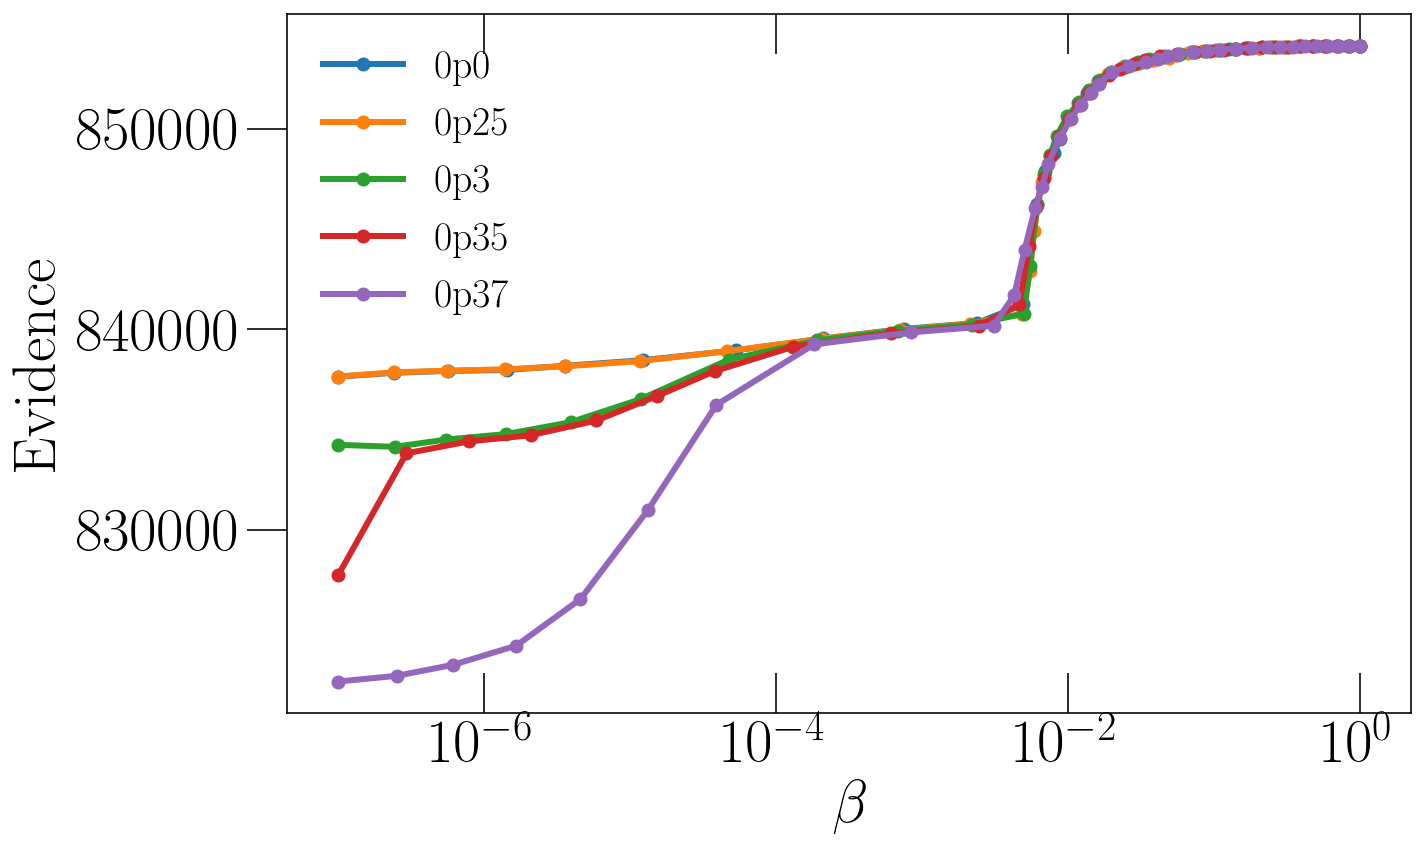

In [21]:
## Plot the Bayeswave evidences
fig = plt.figure(figsize=(10, 6))
    
#for SNR in ['25', '75', '125']:
SNR = '125'
for ell in ["0p0", "0p25", "0p3", "0p35", "0p37"]:
    
    base_dir = 'dCS_' + ell + '_' + SNR
    temp, evidence = GetEvidenceTemps(base_dir) 
    plt.plot(temp, evidence, '-o', label = ell)
    
plt.xscale('log')
plt.ylabel(r'Evidence', fontsize=30)
plt.xlabel(r'$\beta$', fontsize=30)
plt.legend(frameon=False, fontsize=20)
plt.tight_layout()
#plt.savefig('EvidenceTemps.pdf') 
plt.show()

## Plot recovered angles

30.123150776222545 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p3/dCS_0p3_mtotal_68_dist_400/BW_dCS_0p3_mtotal_68_dist_400_1e6/trigtime_1126259462.410700560_0.0_0.0_0/


(40000, 2)



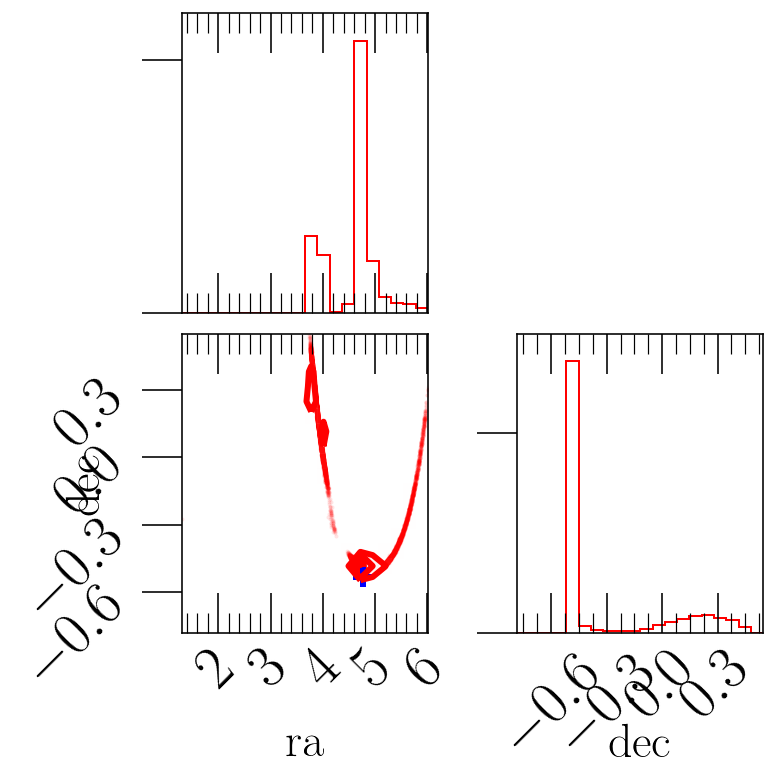

In [48]:
def GetAngles(ell, dist_mpc, mass):
    """ The second and third columns
        The actual values we used were
        ra = 4.7614763656
        dec=-0.531780006467
        
    """
    base_dir = GetBaseDir(ell, dist_mpc, mass)
 
    f = base_dir + "chains/signal_params_h0.dat.0"
    ra, dec = np.loadtxt(f, comments="#",usecols=([1, 2]),unpack=True)
    
    
    return np.transpose(np.array([ra, dec]))
    
## Plot the Bayeswave evidences
mass = 68
dist_mpc = 400

#fig = plt.figure(figsize=(10, 6))
    
ell = [0.3] #, 0.1, 0.2, 0.3]
ell_km = [EllinKm(l, mass) for l in ell]

ndim, nsamples = 2, 10
#samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
#print(samples.shape)
#figure = corner.corner(samples)

for l in ell:
    samples = GetAngles(l, dist_mpc, mass) 
    print(samples.shape)
    fig = corner.corner(samples, color='red', labels=['ra', 'dec'])
    ax_arr = fig.get_axes()
    print()
    ax_arr[2].scatter(4.7614763656, -0.531780006467, color = 'blue', s=100, marker='+')
    
#plt.axvline(-0.531780006467, color='black')
#plt.axvline(4.7614763656, color='black')
#plt.xlabel(r'Declination', fontsize=30)
#plt.legend(frameon=False, fontsize=20)
plt.tight_layout()
plt.show()


## Grab frequency domain data

In [4]:
def GetPSD(ell, dist_mpc, mass, detector, cut = True):
    
    """ Get the PSD from the same place that megaplot.py 
        gets it from. See lines 1565 - 1569 in megaplot.py
        in the ain() method 
        
        Now if 'cut' is True, then set the PSD to 1 before
        125 Hz, which is approximately where we see a difference in the 
        waveform
        """
    
    base_dir = GetBaseDir(ell, dist_mpc, mass)
 
    f = base_dir + "post/signal/signal_median_PSD_" + detector + ".dat"
    freq, val = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True)
    
    if cut:
        index = np.where(freq < 125)[0]
        val[index] = 1.0
        
    return freq, val

def GetBWFrequencyDomainSpectrum(ell, dist_mpc, mass, detector):
    
    """ Get the bayeswave result frequency domain waveform from the 
    same place that megaplot.py gets it from. See lines 1559 - 1563 of
    megaplot.py in the main() method """
    
    base_dir = GetBaseDir(ell, dist_mpc, mass)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_spectrum_" \
                                                               + detector + ".dat"
    freq, re, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    return freq, re, d2, d3, d4, d5

def GetBWFrequencyDomainWaveform(ell, dist_mpc, mass, detector):
    
    """ Ignore the first column, it's wrong. The second line is the median with alternating real and imaginary waveforms
    The first line is h_R at f=0, the second line is h_I at f=0 etc """
    
    base_dir = GetBaseDir(ell, dist_mpc, mass)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_" \
                                                               + detector + ".dat"
    freq, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    length = len(freq)
    
    ## Grab the true frequency range
    freq = freq[0:int(length/2)]
    
    ## Now split up the median into real and imaginary parts
    d1 = d1[0::2] + 1j*d1[1::2]
    d2 = d2[0::2] + 1j*d2[1::2]
    d3 = d3[0::2] + 1j*d3[1::2]
    d4 = d4[0::2] + 1j*d4[1::2]
    d5 = d5[0::2] + 1j*d5[1::2]
    return freq, d1, d2, d3, d4, d5

def GetInjectedFrequencyDomainWaveform(ell, dist_mpc, mass, detector):
    
    """ Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = GetBaseDir(ell, dist_mpc, mass)
 
    f = base_dir + "waveforms/fourier_domain_data_" + detector + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im   

## Plot frequency domain data

0.0 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
10.04105025874085 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0p1_mtotal_68_dist_400/BW_dCS_0p1_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0p1_mtotal_68_dist_400/BW_dCS_0p1_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0p1_mtotal_68_dist_400/BW_dCS_0p1_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
20.0821005174817 m
/home/maria.okounkova/BeyondGRAnalysis/Fram

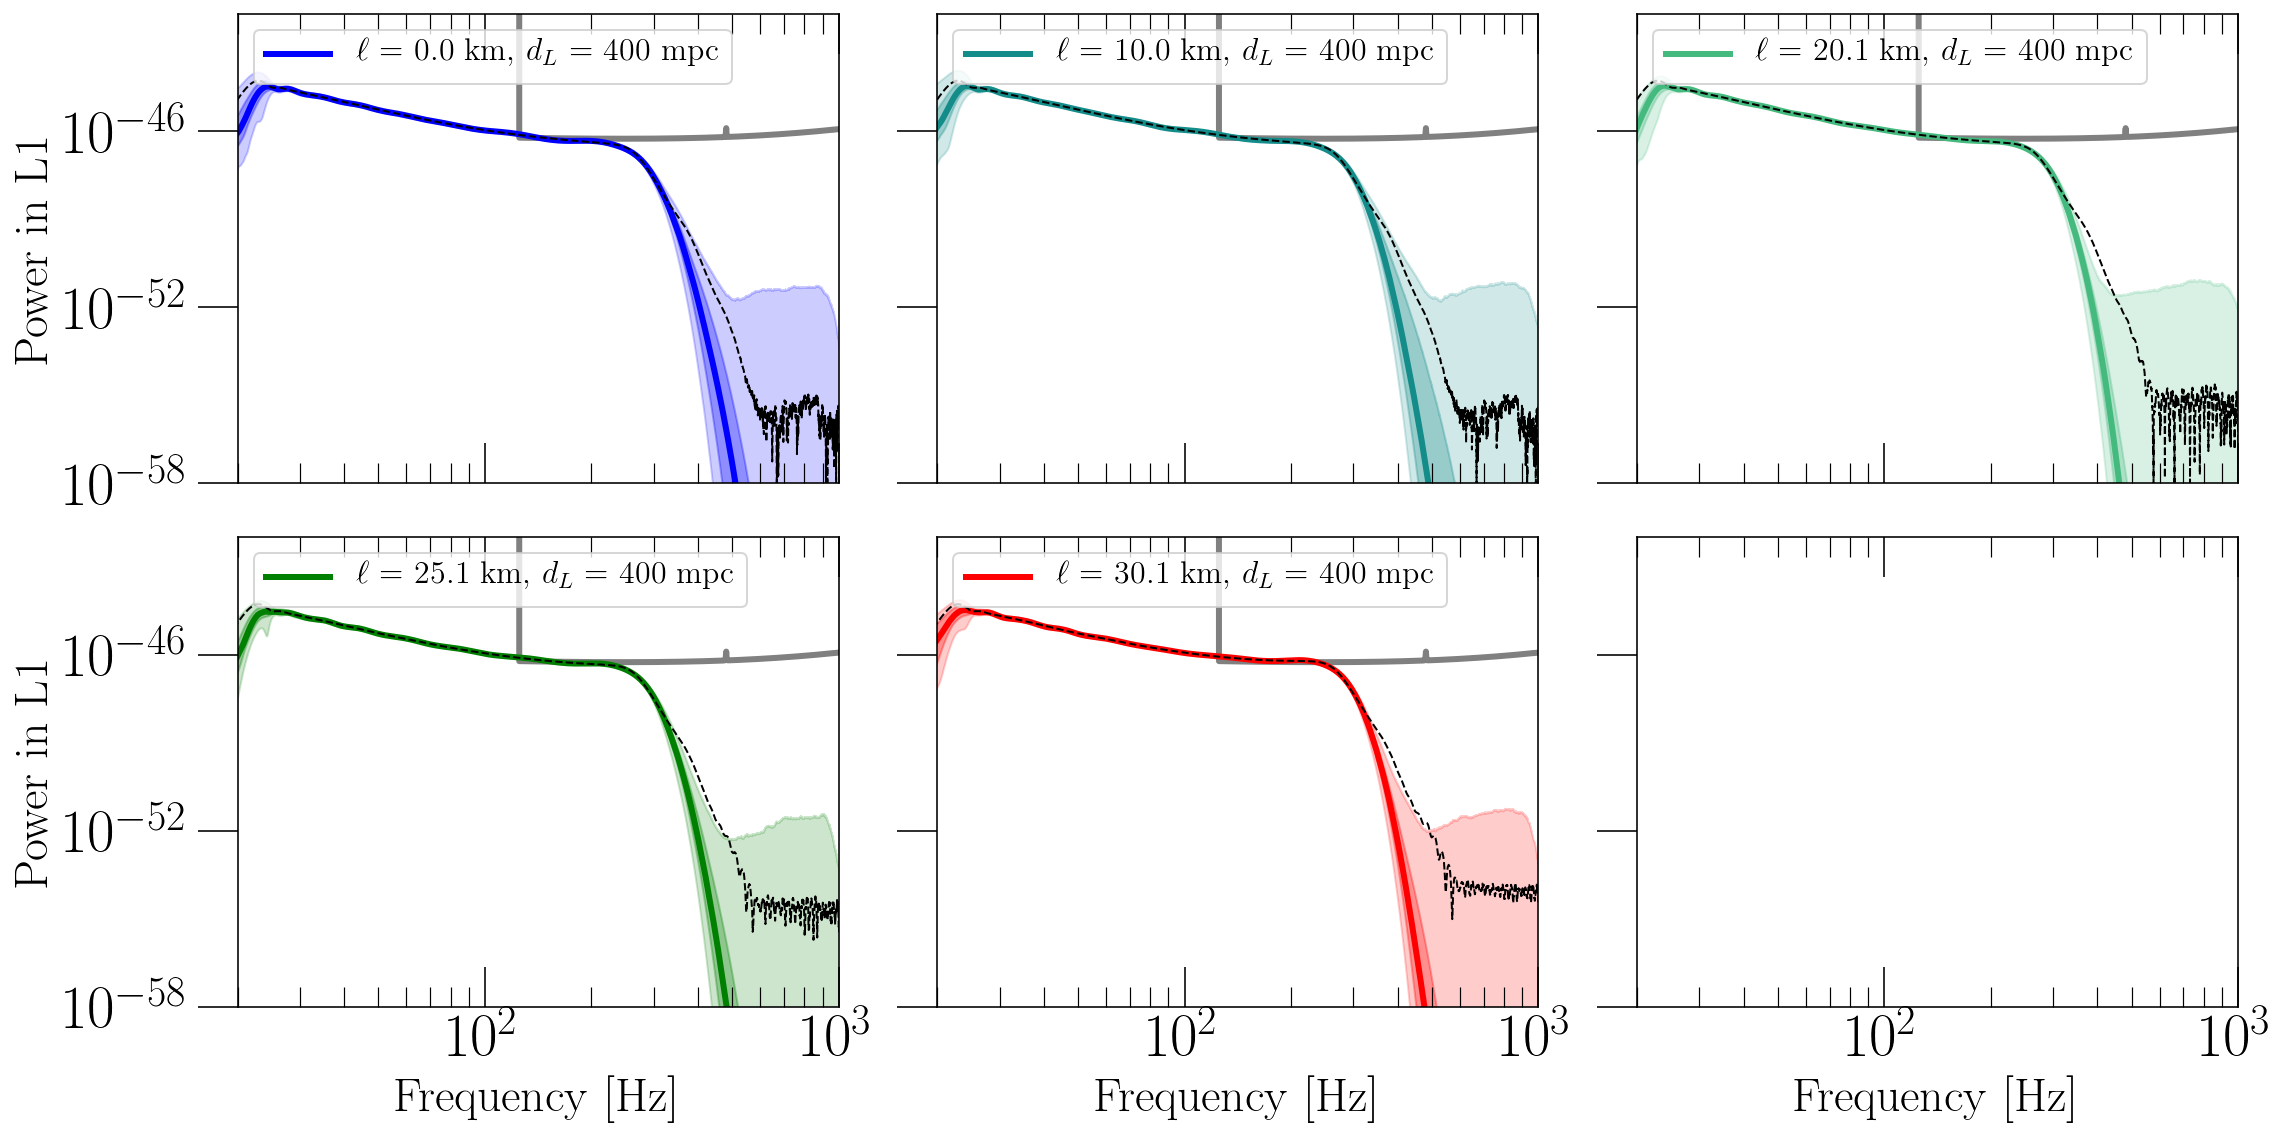

In [45]:
def PlotFrequencyData(ax, ell, dist_mpc, mass, color):
    
    label = r'$\ell$ = ' + EllinKm(ell, mass) + ', $d_L$ = ' + str(dist_mpc) + ' mpc' 
    
    freq, psd = GetPSD(ell, dist_mpc, mass, "L1")
    freq, bw, d2, d3, d4, d5 = GetBWFrequencyDomainSpectrum(ell, dist_mpc, mass, "L1")
    freq, inj = GetInjectedFrequencyDomainWaveform(ell, dist_mpc, mass, "L1")
    
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    ax.plot(freq, psd, color='grey')
    ax.plot(freq, bw, label = label, color=color)
    ax.fill_between(freq, d2, d3, alpha = 0.3, color=color, edgecolor=None)
    ax.fill_between(freq, d4, d5, alpha = 0.2, color=color, edgecolor=None)
    ax.plot(freq, op(inj), color='black', ls='--', lw=1.0) 
   
    
    #freq, bayes = GetBWFrequencyDomainWaveform(ell, SNR, "L1")
    #ax.plot(freq, np.real(bayes)**2 + np.imag(bayes)**2)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(20, 1000)
    ax.set_ylim(1e-58, 1e-42)
    ax.legend(frameon=True, fontsize=16, loc='upper left')

fig, axarr = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

mass = 68
dist_mpc = 400
PlotFrequencyData(axarr[0][0], 0.0, dist_mpc, mass, 'blue')
PlotFrequencyData(axarr[0][1], 0.1, dist_mpc, mass, '#148c8a')
PlotFrequencyData(axarr[0][2], 0.2, dist_mpc, mass, '#45ba7e')
PlotFrequencyData(axarr[1][0], 0.25, dist_mpc, mass, 'green')
PlotFrequencyData(axarr[1][1], 0.3, dist_mpc, mass, 'red')


#plt.legend(frameon=False, fontsize=20)
#plt.ylabel('Power in L1')
for i in range(3):
    axarr[1][i].set_xlabel('Frequency [Hz]')
for i in range(2):
    axarr[i][0].set_ylabel('Power in L1')

plt.tight_layout()
plt.savefig('BayeswaveFreq.pdf')

plt.show()


## Compute overlaps

/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
[0.001494397364503408]
0.0 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0

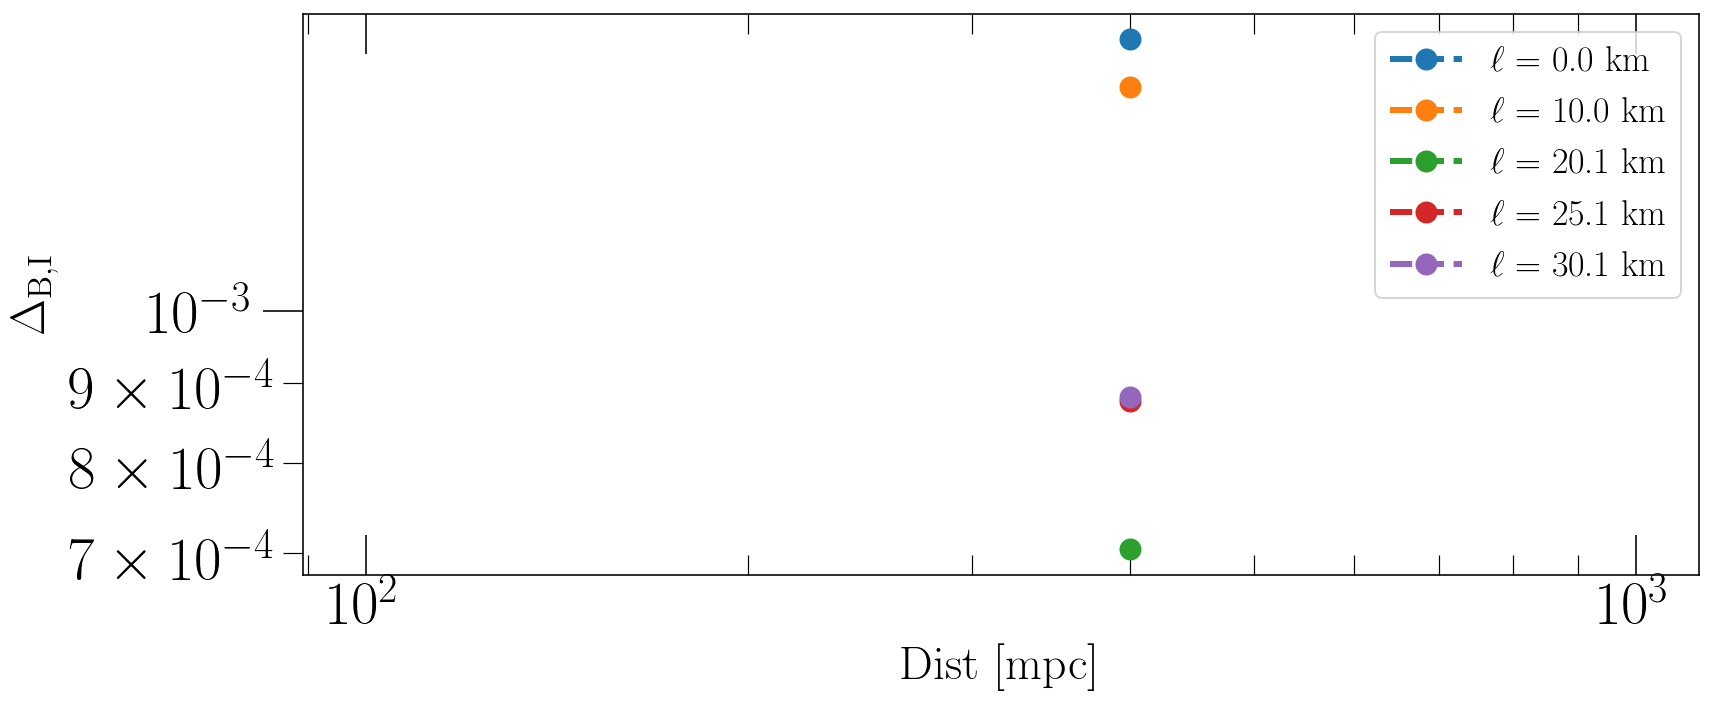

In [61]:

def InnerProduct(freq, hA, hB, PSD):

    """ Compute the inner product using the conventions of 
    https://arxiv.org/abs/2003.09456 Eq. 8"""
    
    ## Spacing in frequency
    df = freq[1] - freq[0]
    
    ## Terms inside the integral
    product = hA * np.conj(hB) / PSD 
    
    ## Compute the integral 
    total = 4.0 * np.real(np.sum(product)) * df
    return total
    
def Overlap(ell, dist_mpc, mass):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    total_bw_inj = 0.0
    total_bw_bw = 0.0
    total_inj_inj = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, dist_mpc, mass, detector)
        freq, bw, d2, d3, d4, d5 = GetBWFrequencyDomainWaveform(ell, dist_mpc, mass, detector)
        freq, inj = GetInjectedFrequencyDomainWaveform(ell, dist_mpc, mass, detector)
        
        total_bw_inj = total_bw_inj + InnerProduct(freq, bw, inj, psd)
        total_bw_bw = total_bw_bw + InnerProduct(freq, bw, bw, psd)
        total_inj_inj = total_inj_inj + InnerProduct(freq, inj, inj, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_bw_inj / np.sqrt(total_bw_bw  * total_inj_inj)
    return overlap
    

plt.figure(figsize=(12, 5))

ells = [0.0, 0.1, 0.2, 0.25, 0.3]
#colors = ['blue', '#148c8a', '#45ba7e']
dist_arr = [400]
mass = 68

for ell in ells:
    
    ## compute the overlap for the median waveform
    deltas = [1.0 - Overlap(ell, dist, mass) for dist in dist_arr]
    print(deltas)
    plt.plot(dist_arr, deltas, '--o', label=r'$\ell$ = ' + EllinKm(ell, mass), markersize=10)
    
## Add in 1/SNR^2 curve 
#snrs = np.linspace(SNRs[0], SNRs[-1], 100)
#snr_curve = snrs**-2.0
#plt.plot(snrs, snr_curve*100, color='black')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$\Delta_\mathrm{B,I}$')
plt.xlabel('Dist [mpc]')
plt.tight_layout()
plt.savefig('Deltas.pdf')

plt.show()
    

## Plot the injected waveforms for various NR resolutions and compute the mismatches

In [ ]:
def GetResInjectedData(ell, SNR, res):
    
    base_dir = GetBaseDir(ell, SNR, res=res)
    
    f = base_dir + 'post/whitened_data_L1.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data
    
def PlotResInjectedData(ell, SNR, res, color, ls, label):
    
    ## Plot the Bayeswave data
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    freq, data = GetInjectedFrequencyDomainWaveform(ell, SNR, 'L1', res=res)
    plt.plot(freq, op(data), lw = 3.0, alpha=1.0, label=label, \
                color = color, ls = ls)
    
fig, ax = plt.subplots(1, figsize=(10, 10), sharex=True)

cs = sns.color_palette('husl', n_colors=6)
    
i = 0
SNR = 150
for ell, label, ls in zip([0.0, 0.226], ['GR', 'dCS-modified'], ['-', '--']):
        
    for lev, res in zip([0,1,2], ['Low', 'Med', 'High']):
        
        lab=label+', ' + res
        PlotResInjectedData(ell, SNR, lev, color=cs[i], ls=ls, label=lab)
        i = i + 1

## Plot the noise curve
freq, psd = GetPSD(0.0, SNR, "L1", cut=False)
plt.plot(freq, psd, color='black', ls = '-', lw = 7.0, label='PSD', alpha=0.4)

freq, psd = GetPSD(0.0, SNR, "L1")
plt.plot(freq, psd, color='black', ls = '--', lw = 1.4, label='Restricted PSD')

plt.xlabel('Frequency [Hz]', fontsize=30) 
plt.ylabel(r'L1 Injected', fontsize=30)

plt.ylim(7e-48, 2e-46)
plt.xlim(100, 350)
plt.legend(loc='upper right', frameon=False)
plt.yscale('log')

## Put text in about the mismatches - from the cell below
## 5.85301418321027e-06
## 8.885879811848518e-06
## 0.00042500416098467664
plt.text(110, 2e-47, r'GR-GR mismatch: $5.85 \times 10^{-6} $', fontsize=24)
plt.text(110, 1.65e-47, r'dCS-dCS mismatch: $8.88 \times 10^{-6} $', fontsize=24)
plt.text(110, 1.2e-47, r'GR-dCS mismatch: $4.25 \times 10^{-4} $', fontsize=24)

plt.tight_layout()
plt.savefig('Injected.pdf')

plt.show()

## Resolution overlaps

In [ ]:
def ResolutionOverlap(SNR, ell1, ell2, res1, res2):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    total_11 = 0.0
    total_12 = 0.0
    total_22 = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, SNR, detector)
        
        freq, inj1 = GetInjectedFrequencyDomainWaveform(ell1, SNR, detector, res = res1)
        inj1 = op(inj1)
        freq, inj2 = GetInjectedFrequencyDomainWaveform(ell2, SNR, detector, res = res2)
        inj2 = op(inj2)
        
        total_11 = total_11 + InnerProduct(freq, inj1, inj1, psd)
        total_12 = total_12 + InnerProduct(freq, inj1, inj2, psd)
        total_22 = total_22 + InnerProduct(freq, inj2, inj2, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_12 / np.sqrt(total_11  * total_22)
    return 1 - overlap

def ResolutionOverlapFigure():

    plt.figure(figsize=(8, 4))
    
    SNR = 150
    
    def Line(ell1, ell2, label, color):
        data = [ResolutionOverlap(150, ell1, ell2, 0, 2), ResolutionOverlap(150, ell1, ell2, 1, 2)]
        print(ResolutionOverlap(150, ell1, ell2, 1, 2))
        plt.plot([0,1], data, '-o', label = label, color=color)
    
    ell = 0.226
    Line(0.0, 0.0, 'GR, GR', 'black')
    Line(ell, ell, 'dCS, dCS', 'gray')
    Line(0.0, ell, 'GR, dCS', 'red')
    
    plt.yscale('log')
    plt.xticks([0, 1], ['Lev0 - Lev2', 'Lev1 - Lev2'], rotation = 90)
    plt.xlim(-0.5, 1.5)
    plt.ylabel('1 - Overlap')
    plt.legend()
    plt.show()
    

ResolutionOverlapFigure()

print(4e-4)
